In [1]:
!pip install soynlp
!pip install konlpy
!pip install nltk
!pip install spacy
!pip install transformers
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 74.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [konlpy]2m2/3 [konlpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 93.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.6/874.6 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 131.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [spacy]m16/17 [spacy]d]sh]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 67

In [44]:
# 핵심 모듈 예시
from soynlp.tokenizer import LTokenizer
from soynlp.word import WordExtractor
from soynlp.noun import LRNounExtractor_v2
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib
import matplotlib.pyplot as plt
import konlpy

print(torch.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)
import time
import nltk
import spacy
from transformers import BertTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
import re
import copy


# 버전 확인 (선택)
import soynlp
print(soynlp.__version__)

2.7.1+cu118
2.2.6
3.10.3
0.6.0
0.0.493


In [45]:
# 데이터 다운로드
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2025-11-16 23:23:16--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.10’

ratings_train.txt.1 100%[===================>]  13.95M  41.5MB/s    in 0.3s    

2025-11-16 23:23:18 (41.5 MB/s) - ‘ratings_train.txt.10’ saved [14628807/14628807]

--2025-11-16 23:23:18--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application

In [46]:
USE_FILE = True
TRAIN_PATH = "/home/jovyan/work/ratings_train.txt"
TEST_PATH  = "/home/jovyan/work/ratings_test.txt"

train = pd.read_table(TRAIN_PATH)
test  = pd.read_table(TEST_PATH)
TEXT_COL  = "document"   # NSMC: id, document, label


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


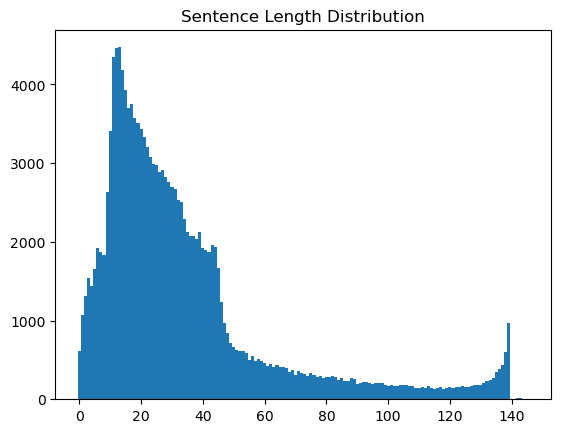

In [47]:
# NSMC train에서 document 컬럼만 리스트로 꺼내기
raw = train['document'].astype(str).tolist()

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [48]:

# 불용어 제거 및 혼용어 정제는 M2팀의 코드를 참고하여 단어집을 늘렸음

# ============================================
# 1) 불용어 제거
# ============================================

random.seed(1); np.random.seed(1)

APPLY_PREPROCESSING = True      # 전처리 적용 여부
REMOVE_STOPWORDS   = True       # 불용어 제거 여부

RAW_STOPWORDS_KO = """
가량, 가지, 각, 간, 갖은, 개, 개국, 개년, 개소, 개월, 걔, 거, 거기, 거리, 건, 것, 겨를, 격,
겸, 고, 군, 군데, 권, 그, 그거, 그것, 그곳, 그까짓, 그네, 그녀, 그놈, 그대, 그래, 그래도,
그서, 그러나, 그러니, 그러니까, 그러다가, 그러면, 그러면서, 그러므로, 그러자, 그런, 그런
데, 그럼, 그렇지만, 그루, 그리고, 그리하여, 그분, 그이, 그쪽, 근, 근데, 글쎄, 글쎄요, 기,
김, 나, 나름, 나위, 남짓, 내, 냥, 너, 너희, 네, 네놈, 녀석, 년, 년대, 년도, 놈, 누구, 니,
다른, 다만, 단, 달, 달러, 당신, 대, 대로, 더구나, 더욱이, 데, 도, 동, 되, 두, 두세, 두어,
둥, 듯, 듯이, 등, 등등, 등지, 따라서, 따름, 따위, 딴, 때문, 또, 또는, 또한, 리, 마당, 마련,
마리, 만, 만큼, 말, 매, 맨, 명, 몇, 몇몇, 모, 모금, 모든, 무렵, 무슨, 무엇, 뭐, 뭣,
및, 바, 바람, 바퀴, 박, 발, 발짝, 번, 벌, 법, 별, 본, 부, 분, 뻔, 뿐, 살, 새, 서너, 석, 설,
섬, 세, 셈, 쇤네, 수, 순, 식, 씨, 아, 아냐, 아니, 아니야, 아무,
아무개, 아무런, 아아, 아이, 아이고, 아이구, 야, 약, 양, 얘, 어, 어느, 어디, 어머, 언제, 에이,
엔, 여기, 여느, 여러, 여러분, 여보, 여보세요, 여지, 역시, 예, 옛, 오, 오랜, 오히려, 온, 온갖,
올, 왜냐하면, 왠, 외, 요, 우, 우리, 원, 월, 웬, 위, 음, 응, 이, 이거, 이것, 이곳, 이놈, 이래,
이런, 이런저런, 이른바, 이리하여, 이쪽, 일, 일대, 임마, 자, 자기, 자네, 장, 저, 저것, 저기,
저놈, 저런, 저쪽, 저편, 저희, 적, 전, 점, 제, 조, 주, 주년, 주일, 줄, 중, 즈음, 즉, 지, 지경,
지난, 집, 짝, 쪽, 쯤, 차, 참, 채, 척, 첫, 체, 측, 치, 큰, 타, 터, 턱, 
통, 투, 판, 퍼센트, 편, 평, 푼, 풉,하기야,하, 하긴, 하물며, 하지만, 한, 한두, 한편, 허허, 헉,헌, 현,
호, 혹은, 휴ㅡ 회, 흥, 흠, 진짜, 정말,엄청,무지
"""

STOPWORDS = sorted({
    w.strip()
    for part in RAW_STOPWORDS_KO.split(',')
    for w in [part.strip()]
    if w.strip()
})

# 불용어목록:Kil Ho-Hyun. (2018). The Study of Korean Stopwords list for Text mining. Urimalgeul: The Korean Language and Literature, 78, 1-25.

# ============================================
# 2) 혼용어 및 오타 정제
# ============================================

SPELLING_DICT = {
    # 재미 / 노잼 계열
    '재밌': [
        '재밌', '재밋', '재미있', '재미잇',
        '잼있', '잼잇', '잼밌', '잼밋',
        '재밌음', '재밌어', '재밌다', '재밌네',
        '잼있음', '잼있어', '잼나', '잼남','재밓'
    ],
    '노잼': [
        '노잼', '개노잼', '존노잼', '핵노잼', '킹노잼',
        '노잼임', '노잼이네', '노잼이야'
    ],
    '꿀잼': [
        '꿀잼', '개꿀잼', '존꿀잼', '핵꿀잼',
        '킹잼', '꿀재밌', '개잼', '졸잼'
    ],

    # 맛/맛있다 계열
    '맛있': [
        '맛있', '맛잇', '마싯', '마싰',
        '맛있다', '맛잇다', '맛있음', '맛있어',
        '존맛', '존맛탱', '존맛탱구리',
        '개맛있', '개맛잇', '핵맛있', '쩌는맛'
    ],
    '별로': [
        '별로', '별루', '별로임', '별로다', '별로야'
    ],

    # 좋다 / 싫다 계열
    '굳':   ['궅', '굳', '굿'],
    '좋': [
        '좋', '좋다', '좋아', '좋음', '좋앗다', '좋앗어',
        '조아', '조음', '졓', '죻',
        '개좋', '개좋다', '존좋', '짱좋'
    ],
    '싫': [
        '싫', '싫다', '싫어', '싫음', '싫엇다',
        '시러', '시름', '싫긔'
    ],

    # 감정/평가 계열
    '대박': [
        '대박', '대박임', '대박이야', '대박이다',
        '대박이네', '대박이었다', '대박이엇다'
    ],
    '헐': [
        '헐', '헐..', '헐...', '헐ㅋ', '헐ㅋㅋ', '헐ㅠ'
    ],
    '짱': [
        '짱', '짱임', '짱이야', '짱이다', '짱좋', '짱좋다'
    ],
    '쩔': [
        '쩔', '쩐다', '쩔어', '쩔음', '쩔었다'
    ],
    '슬프': [
        '슬프', '슬프다', '슬퍼', '슬펐', '슬펐다', '슬펐어'
    ],
    '행복': [
        '행복', '행벅', '행복해', '행복하다', '행복함', '행복햇'
    ],
    '짜증': [
        '짜증', '짜증남', '짜증남ㅋ', '짜증나', '짜증이남',
        '짜쯩', '짜쯩남', '짜쯩나'
    ],
    '불편': [
        '불편', '불편해', '불편하다', '불편함', '불폄'
    ],
    '감동': [
        '감동', '감덩', '감동임', '감동이야', '감동이다', '감동적'
    ],
    '미쳤': ['미첫', '미쳣', '미첬', '미쳤', 'ㅁㅊ'],
    '괜찮': ['괜찮', '괜춘', '괜찬', 'ㄱㅊ', '갠찬', '갠찮', '괸찬', '괸찮'],

    # 귀여움 / 외모 표현
    '귀엽': [
        '귀엽', '귀엽다', '귀여워', '귀여움', '귀여웡',
        '졸귀', '졸귀탱', '졸귀임', '졸귀다', '개귀엽'
    ],
    '예쁘': [
        '예쁘', '예쁘다', '이쁘', '이쁘다',
        '이뻐', '예뻐', '이뻤다', '예뻤다'
    ],

    # 기타 자주 보이는 축약/오타
    '진짜': [
        '진짜', '찐짜', '찐자', '진쨔', '진쨰', 'j짜'
    ],
    '완전': [
        '완전', '왕창', '완전이야', '완죤', '완죤히'
    ],
    '오늘': [
        '오늘', '오눌', '온ㄹ'
    ],
    '사랑': [
        '사랑', '사랑해', '사랑햇', '사랑했다', '사랑한다'
    ],

    # 맞춤법/표기 혼동 교정 계열
    '돼': ['돼', '되'],                # '되'와 '돼' 혼용
    '안': ['안', '않'],                # '안'과 '않' 혼용
    '왠지': ['왠지', '웬지'],          # '왠지'가 맞는 표현
    '어이없다': ['어이없다', '어의없다'],
    '며칠': ['며칠', '몇일'],
    '이따가': ['이따가', '있다가'],
    '로서': ['로서', '로써'],          # 자격/수단 구분 없이 통일용
    '가리키다': ['가리키다', '가르키다'],
    '오랜만에': ['오랜만에', '오랫만에'],
    '금세': ['금세', '금새'],
    '드러나다': ['드러나다', '들어나다'],
    '설레': ['설레', '설래'],
    '바라': ['바라', '바래'],
    '돼요': ['돼요', '되요'],
    '뵈요': ['뵈요', '봬요'],
    '빨리': ['빨리', '빨랑'],
    '힘들다': ['힘들다', '힘듦', '힘듬'],
    '낳다': ['낳다', '낫다'],
    '꺼': ['꺼', '거'],
    '했어': ['했어', '햇어'],
    '봤':   ['봤', '봣', '봣다', '봣음', '봣어요'],
    '겠':   ['겟', '겠'],
}



# ============================================
# 3) 전처리 함수 정의
# ============================================

# ----------------------------------------------------
# 3-0. 특수문자 / 유니코드 기호 정의
# ----------------------------------------------------
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' \
        + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

punct_mapping = {
    "‘": "'",  "’": "'",  "`": "'",
    "“": '"',  "”": '"',

    "₹": "e",  "€": "e",  "£": "e",
    "™": "tm",

    "√": " sqrt ",
    "×": "x",
    "²": "2",
    "³": "3",
    "π": "pi",

    "—": "-",
    "–": "-",
    "−": "-",

    "∞": "infinity",
    "θ": "theta",
    "÷": "/",
    "α": "alpha",
    "•": ".",

    "à": "a",
    "∅": "",
}

specials = {
    "\u200b": " ",   # zero-width space
    "…": " ... ",
    "\ufeff": "",
}


# ----------------------------------------------------
# 3-1. 유니코드/특수문자 정규화
# ----------------------------------------------------
def normalize_punct(text: str) -> str:
    # 1) 특수문자 매핑
    for p, rep in punct_mapping.items():
        text = text.replace(p, rep)

    # 2) 구두점 앞뒤에 공백
    for p in punct:
        text = text.replace(p, f" {p} ")

    # 3) 그 외 특수 토큰
    for s, rep in specials.items():
        text = text.replace(s, rep)

    return text


# ----------------------------------------------------
# 3-2. 한글 슬랭/오타 정규화 (SPELLING_DICT 사용)
# ----------------------------------------------------
def normalize_spelling(text: str) -> str:
    # SPELLING_DICT는 외부에서 정의했다고 가정
    for correct, variants in SPELLING_DICT.items():
        for v in variants:
            # 굳이 자기 자신을 다시 replace할 필요는 없으니 체크
            if v == correct:
                continue
            text = text.replace(v, correct)
    return text


# ----------------------------------------------------
# 3-3. 메인 전처리 함수
# ----------------------------------------------------
def preprocess_text(text, remove_stopwords: bool = True) -> str:
    """
    - 유니코드/구두점 정리
    - 한글 슬랭/오타 정규화 (SPELLING_DICT)
    - 반복 문자/반복 구두점 정리
    - 한글 자모 제거, HTML 제거, 숫자/특수문자 정리
    - 불용어/조사 제거(STOPWORDS)까지 한 번에 수행
    """
    # NaN 처리
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""
    text = str(text)

    # 0) HTML 태그 제거 (크롤링 데이터 대비)
    text = re.sub(r"<[^>]+>", " ", text)

    # 1) 유니코드/특수문자 정규화
    text = normalize_punct(text)

    # 2) 반복되는 문장 부호 제거 (!!! → !!, …… → …)
    text = re.sub(r"([.!?…;])\1+", r"\1", text)

    # 3) 한글 슬랭/오타 정규화
    text = normalize_spelling(text)

    # 4) 반복 문자(ㅋㅋㅋ, ㅎㅎㅎㅎ 등) 3번 이상 → 2번
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # 5) 한글 자모(ㄱ-ㅎ, ㅏ-ㅣ) 단독 제거
    text = re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", " ", text)

    # 6) 숫자 제거 (원하면 살려도 됨)
    text = re.sub(r"\d+", " ", text)

    # 7) 허용 문자만 남기기 (한글, 영문, 숫자, 공백, 기본 구두점)
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,-]", " ", text)

    # 8) 구두점 앞뒤에 공백 (한글 필터 이후 한 번 더 안정화)
    text = re.sub(r"([.!?,-])", r" \1 ", text)

    # 9) 영문 소문자로
    text = text.lower()

    # 10) 연속 공백 정리
    text = re.sub(r"\s+", " ", text).strip()

    # 11) 불용어 제거
    if remove_stopwords:
        # STOPWORDS는 외부에서 정의했다고 가정
        words = text.split()
        filtered_words = []

        for word in words:
            # (1) 단어 전체가 불용어이면 스킵
            if word in STOPWORDS:
                continue

            # (2) 조사/어미가 STOPWORDS에 포함된 경우, 뒤에서 떼기
            removed = False
            for sw in sorted(STOPWORDS, key=len, reverse=True):
                if len(word) > len(sw) and word.endswith(sw):
                    stem = word[:-len(sw)]
                    # 너무 짧게 잘리면 노이즈라 2글자 이상일 때만 유지
                    if len(stem) >= 2:
                        filtered_words.append(stem)
                        removed = True
                        break
            if not removed:
                filtered_words.append(word)

        text = " ".join(filtered_words)

    # 12) 마지막으로 공백 재정리
    text = re.sub(r"\s+", " ", text).strip()

    return text


# ----------------------------------------------------
# 4. 리스트/시리즈에 한 번에 적용하는 편의 함수
# ----------------------------------------------------
def preprocess_corpus(texts, remove_stopwords: bool = True):
    """
    리스트/시리즈 전체에 preprocess_text를 적용해 새로운 리스트 반환
    """
    return [preprocess_text(t, remove_stopwords=remove_stopwords) for t in texts]

def preprocess_dataframe(df, text_col=TEXT_COL):
    """
    데이터프레임 전처리 함수
    """
    print(f"전처리 전 데이터 크기: {len(df)}")
    
    # 1. 결측치 제거
    df = df.dropna(subset=[text_col])
    print(f"결측치 제거 후: {len(df)}")
    
    # 2. 텍스트 전처리 적용
    df[text_col] = df[text_col].apply(preprocess_text)
    
    # 3. 전처리 후 빈 문자열 제거
    df = df[df[text_col].str.strip() != '']
    print(f"빈 문자열 제거 후: {len(df)}")
    
    # 4. 중복 행 제거
    df = df.drop_duplicates(subset=[text_col])
    print(f"중복 제거 후: {len(df)}")
    
    # 인덱스 재설정
    df = df.reset_index(drop=True)
    
    return df


# 샘플 텍스트로 테스트
sample_texts = [
    "어제 본 영화 진짜 재밌었음!!! 또 보고 싶어 😂",
    "나는 오늘 아침에 학교에 갔다. 근데 너무 졸렸음ㅋㅋㅋㅋ",
    "밥은 먹었니?? 아직이야... 점심에 같이 먹자!!!",
    "메캅 형태소 분석은 한국어 처리에서 많이 사용돼 👍",
    "파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자!!!",
    "요즘 코사인 유사도 기반 벡터 검색으로 RG 구축을 많이 해!!",
    "에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어. 굳!",
    "이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ",
    "배우 연기 굳이 훌륭했음, 스토리는 봣지만...",
    "이건 ㄱㅊ 영화네, 굿굿!"
]

print("=" * 80)
print("샘플 텍스트 전처리 결과")
print("=" * 80)
for i, text in enumerate(sample_texts, 1):
    processed = preprocess_text(text)
    print(f"\n[{i}] 원본: {text}")
    print(f"    결과: {processed}")

print("\n" + "=" * 80)
print("실제 데이터 적용 예시")
print("=" * 80)

train_processed = preprocess_dataframe(train.copy())
test_processed = preprocess_dataframe(test.copy())

print("\n전처리 완료!")
print(f"Train 데이터: {len(train_processed)}개")
print(f"Test 데이터: {len(test_processed)}개")
 
print("\n전처리 결과 샘플:")
print(train_processed.head(10))

# ============================================
# 3) 텍스트 로딩 함수
# ============================================

def load_texts():
    if USE_FILE:
        try:

            # 컬럼 확인
            print(f"📋 파일 컬럼: {train_processed.columns.tolist()}")
            print(f"📊 전체 행 수: {len(train_processed):,}")

            # 텍스트 컬럼 선택
            if TEXT_COL in train_processed.columns:
                col = TEXT_COL
            elif "text" in train_processed.columns:
                col = "text"
            else:
                # 두 번째 컬럼을 텍스트로 간주 (일반적으로 id, document, label 순서)
                col = train_processed.columns[1] if len(train_processed.columns) > 1 else train_processed.columns[0]

            print(f"📝 사용할 텍스트 컬럼: '{col}'")

            # # 혹시 모를 결측/빈문자열 재검사 (방어)
            df_clean = train_processed.dropna(subset=[col])
            df_clean = df_clean[df_clean[col].astype(str).str.strip() != ""]
            print(f"🧹 최종 사용 행 수: {len(df_clean):,}개")

             # ⚠️ 여기서는 다시 preprocess_text 돌리지 않고, 바로 사용
            texts = df_clean[col].astype(str).tolist()
            status = "전처리 완료(train_processed 활용)"
            print(f"✅ 파일 로드 및 {status}: {len(texts):,}개 문서")
            
        except FileNotFoundError:
            print(f"❌ 파일을 찾을 수 없습니다: {train_processed}")
            print(f"ℹ️  sample_texts 사용")
            texts = [preprocess_text(t) if APPLY_PREPROCESSING else t for t in sample_texts]

        except Exception as e:
            print(f"❌ 파일 로드 중 오류 발생: {e}")
            print(f"ℹ️  sample_texts 사용")
            texts = [preprocess_text(t) if APPLY_PREPROCESSING else t for t in sample_texts]

    else:
        texts = [preprocess_text(t) if APPLY_PREPROCESSING else t for t in sample_texts]
        status = "전처리 적용" if APPLY_PREPROCESSING else "원본 사용"
        print(f"ℹ️  sample_texts 사용 ({status}): {len(texts)}개 문서")
    
    return texts


# ============================================
# 4) 실제 실행
# ============================================

texts = load_texts()
print(f"\n📦 최종 분석 문서 수: {len(texts):,}개")
print(f"⚙️  전처리 적용: {'✅ ON' if APPLY_PREPROCESSING else '❌ OFF'}")
print(f"⚙️  불용어 제거: {'✅ ON' if REMOVE_STOPWORDS else '❌ OFF'}")

# 전처리 예시 보여주기
if APPLY_PREPROCESSING:
    print("\n🔍 전처리 예시 (처음 3개 문서):")
    for i, text in enumerate(texts[:3], 1):
        print(f"[{i}] {text}")
else:
    print("\n🔍 원본 텍스트 예시 (처음 3개 문서):")
    for i, text in enumerate(texts[:3], 1):
        print(f"[{i}] {text}")

print("\n" + "="*80)


샘플 텍스트 전처리 결과

[1] 원본: 어제 본 영화 진짜 재밌었음!!! 또 보고 싶어 😂
    결과: 어제 영화 재밌었 ! ! ! 보고 싶어

[2] 원본: 나는 오늘 아침에 학교에 갔다. 근데 너무 졸렸음ㅋㅋㅋㅋ
    결과: 나는 오늘 아침에 학교에 갔다 . 너무 졸렸

[3] 원본: 밥은 먹었니?? 아직이야... 점심에 같이 먹자!!!
    결과: 밥은 먹었 ? ? 아직이 . . . 점심에 같이 먹자 ! ! !

[4] 원본: 메캅 형태소 분석은 한국어 처리에서 많이 사용돼 👍
    결과: 메캅 형태소 분석은 한국 처리에서 많이 사용돼

[5] 원본: 파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자!!!
    결과: 파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자 ! ! !

[6] 원본: 요즘 코사인 유사도 기반 벡터 검색으로 RG 구축을 많이 해!!
    결과: 요즘 코사인 유사 기반 벡터 검색으로 rg 구축을 많이 해 ! !

[7] 원본: 에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어. 굳!
    결과: 에이전트는 외부 도구를 호출해 작업을 자동화할 있어 . 굳 !

[8] 원본: 이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ
    결과: 영화 미쳤다 ! ! ! 너무 재밌

[9] 원본: 배우 연기 굳이 훌륭했음, 스토리는 봣지만...
    결과: 배우 연기 굳이 훌륭했 , 스토리는 봤지 . . .

[10] 원본: 이건 ㄱㅊ 영화네, 굿굿!
    결과: 이건 괜찮 영화 , 굳굳 !

실제 데이터 적용 예시
전처리 전 데이터 크기: 150000
결측치 제거 후: 149995
빈 문자열 제거 후: 149438
중복 제거 후: 143872
전처리 전 데이터 크기: 50000
결측치 제거 후: 49997
빈 문자열 제거 후: 49778
중복 제거 후: 48432

전처리 완료!
Train 데이터: 143872개
Test 데이터: 48432개

전처리 결과 샘플:
         id                      

In [49]:
#Sentence piece

문장의 최단 길이: 1
문장의 최장 길이: 279
문장의 평균 길이: 34


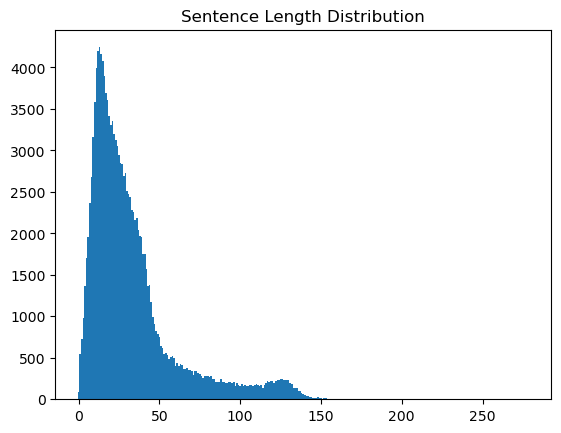

In [50]:
min_len = 999
max_len = 0
sum_len = 0

for sen in texts:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(texts))

sentence_length = np.zeros((max_len), dtype=int)

for sen in texts:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [51]:
def check_sentence_with_length(texts, length):
    count = 0

    for sen in texts:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(texts, 1)

처
잼
즐
억
굳
좋
짱
휴
.
?
쩔
k
쒯
토
o
똥
z
헐
!
삼
꽝
돈
왜
쉣
좇
봐
뿌
-
초
d
찜
귯
린
쨩
시
a
c
딱
웅
앜
b
쩜
뀼
임
뭥
미
로
빠
애
놔
헝
싫
보
f
움
켁
업
둔
앙
g
걍
허
혀
쀍
구
류
갑
끙
욱
즛
라
킥
함
진
파
잠
곧
h
좀
닥
캬
,
풋
품
웩
썅
죽
븅
꺅
욜
핡


In [52]:
# Step 2. SentencePiece 모델 학습

corpus = texts  

class Tokenizer:
    def __init__(self, filters=''):
        self.word_index = {"<UNK>": 1}
        self.index_word = {1: "<UNK>"}
        self.filters = filters

    def fit_on_texts(self, corpus):
        for sentence in corpus:
            tokens = sentence.split() if isinstance(sentence, str) else sentence
            for token in tokens:
                if token not in self.word_index:
                    self.word_index[token] = len(self.word_index) + 1
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def texts_to_sequences(self, corpus):
        sequences = []
        for sentence in corpus:
            tokens = sentence.split() if isinstance(sentence, str) else sentence
            seq = [self.word_index.get(token, 1) for token in tokens]  # 1 = <UNK>
            sequences.append(torch.tensor(seq, dtype=torch.long))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for seq in sequences:
            if isinstance(seq, torch.Tensor):
                seq = seq.tolist()
            tokens = [self.index_word.get(idx, "") for idx in seq if idx != 0]
            texts.append(tokens)
        return texts

def tokenize(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    tensor = pad_sequence(sequences, batch_first=True, padding_value=0)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus) 
print(tensor.shape)          # (문장 수, 최대 시퀀스 길이)
print(len(tokenizer.word_index))  # vocab size
print(tokenizer.sequences_to_texts(tensor[:2]))

torch.Size([143872, 140])
249191
[['더빙', '.', '.', '짜증네', '목소'], ['.', '.', '.', '포스터보', '초딩영화', '.', '.', '.', '.', '오버연기조', '가볍', '안구']]


In [53]:
#search_vocab_size

def search_vocab_size(
    corpus,
    vocab_sizes,
    tmp_dir="spm_vocab_search",
    model_type="unigram",
    character_coverage=0.9995,
    sample_size=50000,   # UNK 비율 계산에 사용할 샘플 문장 수
):
    """
    여러 vocab_size에 대해 SentencePiece를 학습하고,
    각 vocab_size에서의 UNK 비율과 avg_pieces_per_char 등을 비교하는 탐색 함수
    """
    # 0) 코퍼스 정리
    corpus = [str(s).strip() for s in corpus if isinstance(s, str) and str(s).strip()]
    if not corpus:
        print("[search_vocab_size] corpus가 비어 있습니다.")
        return None

    os.makedirs(tmp_dir, exist_ok=True)

    # 1) 코퍼스 파일 하나 만들어 두고 재활용
    corpus_path = os.path.join(tmp_dir, "corpus.txt")
    with open(corpus_path, "w", encoding="utf-8") as f:
        for line in corpus:
            f.write(line.replace("\n", " ") + "\n")

    # 2) UNK 비율 계산용 샘플 문장 선택
    if len(corpus) > sample_size:
        sample_texts = random.sample(corpus, sample_size)
    else:
        sample_texts = corpus

    results = []

    for vs in vocab_sizes:
        model_prefix = os.path.join(tmp_dir, f"spm_{model_type}_{vs}")
        model_file = model_prefix + ".model"

        print(f"\n=== vocab_size={vs} 학습/평가 중 ===")

        # 이미 모델이 있으면 재학습 건너뛰기 (완전 새로 하고 싶으면 tmp_dir 지우고 다시 실행)
        if not os.path.exists(model_file):
            cmd = (
                f"--input={corpus_path} "
                f"--model_prefix={model_prefix} "
                f"--vocab_size={vs} "
                f"--model_type={model_type} "
                f"--character_coverage={character_coverage} "
                "--unk_id=0 --pad_id=1 --bos_id=2 --eos_id=3"
            )
            spm.SentencePieceTrainer.Train(cmd)

        sp = spm.SentencePieceProcessor()
        sp.Load(model_file)

        unk_id = sp.unk_id()
        total_pieces = 0
        total_unk = 0
        total_chars = 0

        # 3) UNK 비율 & avg_pieces_per_char 계산
        for s in sample_texts:
            s = str(s)
            total_chars += len(s)
            ids = sp.EncodeAsIds(s)
            total_pieces += len(ids)
            total_unk += sum(1 for i in ids if i == unk_id)

        unk_ratio = total_unk / total_pieces if total_pieces > 0 else 0.0
        avg_pieces_per_char = (total_pieces / total_chars) if total_chars > 0 else 0.0

        print(
            f"- 토큰 수: {total_pieces:,}, UNK 개수: {total_unk:,}, "
            f"UNK 비율: {unk_ratio:.4%}, pieces/char: {avg_pieces_per_char:.4f}"
        )

        results.append({
            "vocab_size": vs,
            "unk_ratio": unk_ratio,
            "avg_pieces_per_char": avg_pieces_per_char,
            "total_pieces": total_pieces,
            "unk_count": total_unk,
            "model_prefix": model_prefix,
        })

    df = pd.DataFrame(results).sort_values("vocab_size").reset_index(drop=True)
    print("\n=== vocab_size 탐색 결과 ===")
    print(df)

    return df


In [54]:
# 적절한 vocab size 선택

candidate_vocab_sizes = [2000, 4000, 8000, 12000, 16000, 32000]

vocab_search_df = search_vocab_size(
    corpus=texts,
    vocab_sizes=candidate_vocab_sizes,
    tmp_dir="spm_vocab_search_nsmc",
    model_type="unigram",           # 필요하면 'bpe'로도 바꿔서 비교 가능
    character_coverage=0.9995,
)

# 예: UNK 비율이 1% 이하인 것 중에서 가장 작은 vocab_size 선택
if vocab_search_df is not None:
    good = vocab_search_df[vocab_search_df["unk_ratio"] <= 0.01]
    if not good.empty:
        best_row = good.sort_values(
            ["vocab_size", "avg_pieces_per_char"]
        ).iloc[0]
    else:
        # UNK 1% 이하가 하나도 없으면, UNK가 가장 낮은 것 선택
        best_row = vocab_search_df.sort_values(
            ["unk_ratio", "avg_pieces_per_char"]
        ).iloc[0]

    print("\n🏆 추천 vocab size")
    print(best_row)



=== vocab_size=2000 학습/평가 중 ===
- 토큰 수: 1,160,433, UNK 개수: 819, UNK 비율: 0.0706%, pieces/char: 0.6823

=== vocab_size=4000 학습/평가 중 ===
- 토큰 수: 905,166, UNK 개수: 819, UNK 비율: 0.0905%, pieces/char: 0.5322

=== vocab_size=8000 학습/평가 중 ===
- 토큰 수: 789,717, UNK 개수: 819, UNK 비율: 0.1037%, pieces/char: 0.4643

=== vocab_size=12000 학습/평가 중 ===
- 토큰 수: 741,725, UNK 개수: 819, UNK 비율: 0.1104%, pieces/char: 0.4361

=== vocab_size=16000 학습/평가 중 ===
- 토큰 수: 712,852, UNK 개수: 819, UNK 비율: 0.1149%, pieces/char: 0.4191

=== vocab_size=32000 학습/평가 중 ===
- 토큰 수: 657,934, UNK 개수: 819, UNK 비율: 0.1245%, pieces/char: 0.3869

=== vocab_size 탐색 결과 ===
   vocab_size  unk_ratio  avg_pieces_per_char  total_pieces  unk_count  \
0        2000   0.000706             0.682318       1160433        819   
1        4000   0.000905             0.532225        905166        819   
2        8000   0.001037             0.464342        789717        819   
3       12000   0.001104             0.436124        741725        819   

In [55]:
import sentencepiece as spm
import os

# 👉 NSMC 코퍼스용 임시 파일 이름으로 변경
temp_file = "nsmc_spm_corpus.txt"

vocab_size = 16000

with open(temp_file, 'w') as f:
    for row in corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-rw-r-- 1 jovyan users 538739 Nov 16 23:25 korean_spm.model
-rw-rw-r-- 1 jovyan users 312666 Nov 16 23:25 korean_spm.vocab


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=nsmc_spm_corpus.txt --model_prefix=korean_spm --vocab_size=16000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_spm_corpus.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad

In [56]:
# 1. SentencePiece 모델이 정상인지 확인하는 3가지 테스트
# (1)인코딩 → 디코딩 round-trip
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',-1, 0.1))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

# id → piece 직접 대응 확인
for i, pid in enumerate(tokensIDs):
    print(i, pid, "=>", s.IdToPiece(pid))
    
# 복원이 원문과 거의 같으면 OK (띄어쓰기 정도만 아주 약간 다를 수 있음).

#(2) vocab 크기 + 특수 토큰 확인
print("SentencePiece vocab size:", s.GetPieceSize())
print("UNK ID:", s.unk_id(), "토큰:", s.IdToPiece(s.unk_id()))
print("BOS ID:", s.bos_id(),  "토큰:", s.IdToPiece(s.bos_id()))
print("EOS ID:", s.eos_id(),  "토큰:", s.IdToPiece(s.eos_id()))

# vocab_size = 16000 으로 학습했다면 s.GetPieceSize()도 보통 16000 나옵니다.
# <unk>, <s>, </s> 같은 토큰이 잘 보이면 정상.

#(3) NSMC 전체에서 UNK 비율 대략 보기 (선택)
def check_unk_ratio(sp, corpus, sample_n=10000):
    unk_id = sp.unk_id()
    n = min(sample_n, len(corpus))
    total_tokens = 0
    unk_tokens = 0

    for i in range(n):
        ids = sp.EncodeAsIds(corpus[i])
        total_tokens += len(ids)
        unk_tokens += sum(1 for t in ids if t == unk_id)

    return unk_tokens / max(1, total_tokens)

unk_ratio = check_unk_ratio(s, raw)  # raw: NSMC 전체 문장 리스트
print("UNK 비율:", unk_ratio)

#UNK 비율이 너무 높지 않으면 (예: 5~10% 정도면 괜찮고, 30~40% 넘어가면 vocab이 너무 작은 편) 토크나이저 설정도 무난합니다.

[5982, 413, 13, 10562, 154, 15, 15998]
['▁', '아', '버', '지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가방에들어가신다.
0 5982 => ▁아버지가
1 413 => 방
2 13 => 에
3 10562 => 들어가
4 154 => 신
5 15 => 다
6 15998 => .
SentencePiece vocab size: 16000
UNK ID: 0 토큰: <unk>
BOS ID: 1 토큰: <s>
EOS ID: 2 토큰: </s>
UNK 비율: 0.048114722015803774


In [57]:
import sentencepiece as spm
# Step 2에서 학습한 모델 파일 이름을 사용합니다.
s = spm.SentencePieceProcessor()
s.Load("korean_spm.model")

True

In [58]:
import torch
from torch.nn.utils.rnn import pad_sequence # 필수 import

def sp_tokenize(s, corpus):

    tensor = []  # 리스트 이름을 명확하게 변경 (선택 사항이지만 권장)

    for sen in corpus:
        ids = s.EncodeAsIds(sen)
        # 🚨 수정된 부분: 파이썬 리스트(ids)를 torch.tensor로 변환하여 추가
        tensor.append(torch.tensor(ids, dtype=torch.long))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    # 🚨 수정된 부분: Tensor 리스트를 사용하여 패딩을 수행합니다.
    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)

    return tensor, word_index, index_word


In [59]:
import sentencepiece as spm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# 1) SentencePiece 모델 로드
s = spm.SentencePieceProcessor()
s.Load("korean_spm.model")   # 위에서 학습한 모델 파일

# 2) text / label 준비
X = train_processed['document'].astype(str).tolist()
y = train_processed['label'].values  # 0 or 1

# 3) 70% train / 30% valid
num_samples = len(texts)
split_idx = int(num_samples * 0.7)

train_X = X[:split_idx]
train_y = y[:split_idx]

val_X = X[split_idx:]
val_y = y[split_idx:]

print("train:", len(train_X), "valid:", len(val_X))

# 3-1) SentencePiece로 토큰화
train_tensor, word_index, index_word = sp_tokenize(s, train_X)
val_tensor,   _,          _          = sp_tokenize(s, val_X)

print("train_tensor shape:", train_tensor.shape)
print("val_tensor shape:",  val_tensor.shape)


train: 100710 valid: 43162
train_tensor shape: torch.Size([100710, 140])
val_tensor shape: torch.Size([43162, 102])


In [60]:
# 2. NSMC 파이프라인에 잘 붙었는지 확인하는 방법
# (2) vocab_size와 SentencePiece ID의 일치 여부
print("embedding vocab_size:", vocab_size)
print("max token id in train:", train_tensor.max().item())
print("max token id in val:",   val_tensor.max().item())

# max token id가 vocab_size-1보다 크면 안 됩니다.

#둘 다 <= vocab_size-1 이면 Embedding index 범위는 안전해요

embedding vocab_size: 16000
max token id in train: 15997
max token id in val: 15999


In [61]:
# 딥러닝 모델 

import torch
import torch.nn as nn
import torch.nn.functional as F

# vocab_size = s.GetPieceSize() # 이전 코드 블록에서 정의됨
word_vector_dim = 128  # 👉 임베딩 차원을 128로 변경
sp_vocab_size = s.vocab_size()  
PAD_ID = 0                 

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, hidden_size=64):
        super(SentimentModel, self).__init__()
        
        # 1. 임베딩 차원 64, padding_idx=0 설정
        self.embedding = nn.Embedding(vocab_size,
                                      word_vector_dim,
                                      padding_idx=PAD_ID)
        
        # 2. 양방향 LSTM: hidden_size=64, num_layers=2
        self.lstm = nn.LSTM(
            input_size=word_vector_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        # 3. 드롭아웃
        self.dropout = nn.Dropout(p=0.3)
        
        # 4. FC 레이어: 양방향이므로 hidden_size * 2
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: [batch, seq_len]
        x = self.embedding(x)               # [batch, seq_len, word_vector_dim]
        
        # LSTM
        x, (hn, cn) = self.lstm(x)
        # hn: [num_layers * num_directions, batch, hidden_size]
        # 마지막 레이어의 forward, backward hidden state 연결
        # num_directions = 2 → 인덱스 -2: 마지막 레이어 forward, -1: 마지막 레이어 backward
        final_hidden = torch.cat((hn[-2], hn[-1]), dim=1)   # [batch, hidden_size * 2]
        
        x = self.dropout(final_hidden)
        x = self.fc(x)                     # [batch, 1]
        x = torch.sigmoid(x)               # 확률로 변환
        return x

model = SentimentModel(sp_vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(16000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [62]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(train_tensor, dtype=torch.long)
partial_y_train_tensor = torch.tensor(train_y, dtype=torch.float)

x_val_tensor = torch.tensor(val_tensor, dtype=torch.long)
y_val_tensor = torch.tensor(val_y, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 학습의 진행
epochs = 20    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

# ===========================
# ✅ Early Stopping 설정
# ===========================
patience = 5                # 개선 없을 때 몇 epoch 기다릴지
best_val_loss = float("inf")
best_model_state = None
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = val_correct / val_total

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")


    # ===========================
    # ✅ Early Stopping 로직
    # ===========================
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        print(f"  🔁 개선됨! best_val_loss 갱신: {best_val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"  ⚠️ val_loss 개선 없음 ({early_stop_counter}/{patience})")
        if early_stop_counter >= patience:
            print("  ⛔ Early stopping 발동! 학습 조기 종료")
            break

# ===========================
# ✅ 가장 성능 좋았던 모델로 복원
# ===========================
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Early Stopping 후 best_val_loss = {best_val_loss:.4f} 모델로 복원 완료")

cuda


/tmp/ipykernel_105/3332965651.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(train_tensor, dtype=torch.long)
/tmp/ipykernel_105/3332965651.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(val_tensor, dtype=torch.long)


Epoch 1/20 - Train Loss: 0.6140, Train Accuracy: 0.6488 - Validation Loss: 0.5202, Validation Accuracy: 0.7415
  🔁 개선됨! best_val_loss 갱신: 0.5202
Epoch 2/20 - Train Loss: 0.4667, Train Accuracy: 0.7783 - Validation Loss: 0.4472, Validation Accuracy: 0.7882
  🔁 개선됨! best_val_loss 갱신: 0.4472
Epoch 3/20 - Train Loss: 0.3928, Train Accuracy: 0.8225 - Validation Loss: 0.4217, Validation Accuracy: 0.8104
  🔁 개선됨! best_val_loss 갱신: 0.4217
Epoch 4/20 - Train Loss: 0.3531, Train Accuracy: 0.8460 - Validation Loss: 0.4099, Validation Accuracy: 0.8149
  🔁 개선됨! best_val_loss 갱신: 0.4099
Epoch 5/20 - Train Loss: 0.3181, Train Accuracy: 0.8637 - Validation Loss: 0.4035, Validation Accuracy: 0.8240
  🔁 개선됨! best_val_loss 갱신: 0.4035
Epoch 6/20 - Train Loss: 0.2877, Train Accuracy: 0.8797 - Validation Loss: 0.4094, Validation Accuracy: 0.8262
  ⚠️ val_loss 개선 없음 (1/5)
Epoch 7/20 - Train Loss: 0.2609, Train Accuracy: 0.8917 - Validation Loss: 0.4328, Validation Accuracy: 0.8265
  ⚠️ val_loss 개선 없음 (2/5)
E

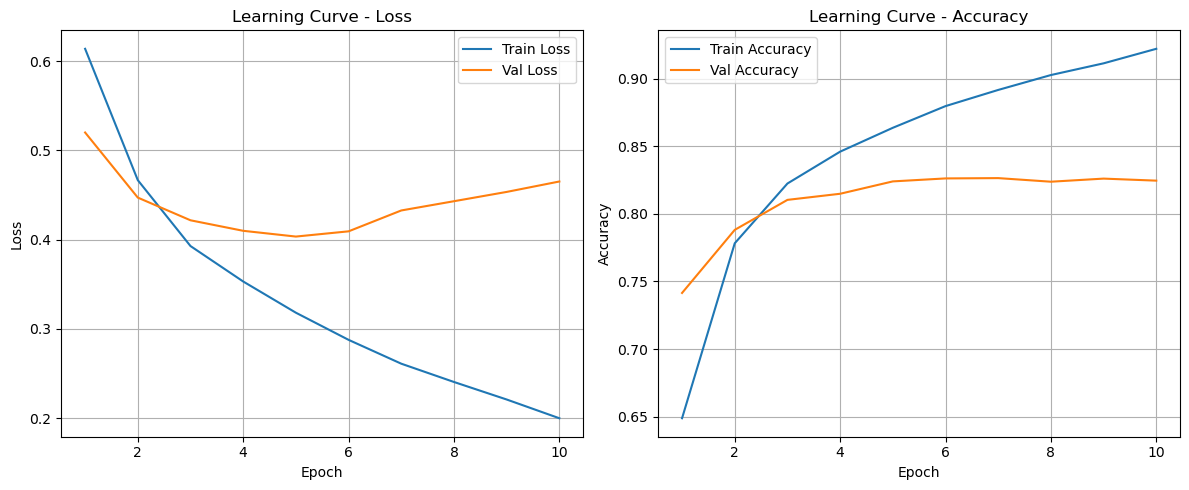

In [63]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열

# (1) Loss curve
axes[0].plot(epochs_range, train_losses, label="Train Loss")
axes[0].plot(epochs_range, val_losses, label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Learning Curve - Loss")
axes[0].legend()
axes[0].grid(True)

# (2) Accuracy curve
axes[1].plot(epochs_range, train_accs, label="Train Accuracy")
axes[1].plot(epochs_range, val_accs, label="Val Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Learning Curve - Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [64]:
import pandas as pd

# 1) NSMC test 데이터 읽기

test_X = test_processed['document'].astype(str).tolist()
test_y = test_processed['label'].values  # 0 or 1

print("test size:", len(test_X))

# 2) SentencePiece 토큰화
test_tensor, _, _ = sp_tokenize(s, test_X)  # s: 이미 로드한 SentencePieceProcessor


print("test_tensor shape:", test_tensor.shape)


test size: 48432
test_tensor shape: torch.Size([48432, 104])


In [65]:
from torch.utils.data import DataLoader, TensorDataset

# test_tensor, test_labels 는 이미 만들어져 있다고 가정
test_x_tensor = torch.tensor(test_tensor, dtype=torch.long)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# ✅ 모델이 올라가 있는 device 가져오기 (이미 device 변수가 있으면 그거 써도 됨)
device = next(model.parameters()).device
print("test device:", device)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # 🔥 여기에서 device로 옮겨줘야 함
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)          # (B, 1)
        outputs = outputs.squeeze(1)     # (B,)

        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(
    f"Test Loss: {test_loss / len(test_loader):.4f}, "
    f"Test Accuracy: {test_correct / test_total:.4f}"
)


test device: cuda:0


/tmp/ipykernel_105/2883956996.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x_tensor = torch.tensor(test_tensor, dtype=torch.long)


Test Loss: 0.4024, Test Accuracy: 0.8228


In [66]:
##토큰나이저##
from collections import Counter
import numpy as np

   
def analyze_tokenizer(
    corpus,                              # ❗ 기본값 제거
    tokenize_one_fn=sp_tokenize,     # (str) -> list[str]
    pos_pairs_one_fn=None,              # (str) -> list[(token, pos)] | None
    top_n=20,
    coverages=(0.9, 0.95, 0.99),
    example_sentences=None,             # ✅ 예시 문장 리스트
    title="Sentencepiece Tokenizer Report",
):
    """
    - 코퍼스로 통계/coverage/상위 토큰 계산
    - 예시 문장은 example_sentences로 별도 받아 토큰화 결과만 출력
    """
    # 0) 코퍼스 정리
    corpus = [s for s in corpus if isinstance(s, str) and s.strip()]
    if not corpus:
        print(f"[{title}] 빈 코퍼스입니다.")
        return {}

    # 1) 코퍼스 토큰화
    token_lists = [tokenize_one_fn(s) for s in corpus]
    flat_tokens = [t for toks in token_lists for t in toks]

    # 2) 기본 통계
    total_tokens = len(flat_tokens)
    avg_tokens_per_sent = float(np.mean([len(toks) for toks in token_lists])) if token_lists else 0.0
    avg_token_char_len = float(np.mean([len(t) for t in flat_tokens])) if flat_tokens else 0.0

    # 3) 품사 비율 (옵션)
    pos_ratio = None
    if pos_pairs_one_fn is not None:
        pos_counter = Counter()
        for s in corpus:
            pairs = pos_pairs_one_fn(s) or []
            pos_counter.update([p for _, p in pairs])
        total_pos = sum(pos_counter.values())
        if total_pos > 0:
            pos_ratio = {p: round(c / total_pos, 4) for p, c in pos_counter.items()}

    # 4) 상위 토큰
    top_tokens = Counter(flat_tokens).most_common(top_n)

    # 5) coverage 기반 vocab size
    freq = Counter(flat_tokens)
    total_freq = sum(freq.values())
    sorted_items = freq.most_common()
    suggested_vocab_size = {}
    for cov in coverages:
        need = total_freq * cov
        acc = 0
        k = 0
        for _, c in sorted_items:
            acc += c
            k += 1
            if acc >= need:
                suggested_vocab_size[cov] = k
                break

    # 6) 요약 출력
    print(f"\n[{title}] 요약")
    print(f"- 전체 문장 수: {len(corpus)}")
    print(f"- 전체 토큰 수: {total_tokens}")
    print(f"- 문장당 평균 토큰 수: {avg_tokens_per_sent:.2f}")
    print(f"- 평균 토큰 '문자' 길이: {avg_token_char_len:.2f}")
    if pos_ratio is not None:
        print("- 품사 비율:")
        for p, r in sorted(pos_ratio.items(), key=lambda x: (-x[1], x[0])):
            print(f"  • {p}: {r:.4f}")

    print(f"\n- 상위 {top_n} 토큰:")
    for tok, cnt in top_tokens:
        print(f"  • \"{tok}\" {cnt}개")

    print("\n- coverage 기준 vocab size 제안:")
    for cov in coverages:
        k = suggested_vocab_size.get(cov, 0)
        print(f"  • {int(cov*100)}% → {k}")

    # 7) 예시 문장 토큰화
    if example_sentences:
        print(f"\n- 예시 문장 {min(len(example_sentences), 5)}개 토큰화:")
        for i, s in enumerate(example_sentences[:5], 1):
            print(f"  {i}. {s}")
            toks = tokenize_one_fn(s)
            if pos_pairs_one_fn is not None:
                pairs = pos_pairs_one_fn(s) or []
                print("     -> tokens:", toks)
                print("     -> pos   :", pairs)
            else:
                print("     ->", toks)

    # 8) 머신 친화 반환
    return {
        "total_tokens": total_tokens,
        "avg_tokens_per_sentence": avg_tokens_per_sent,
        "avg_token_char_length": avg_token_char_len,
        "pos_ratio": pos_ratio,
        "top_tokens": top_tokens,
        "suggested_vocab_size": suggested_vocab_size,
        "examples": [
            (s, tokenize_one_fn(s),
             (pos_pairs_one_fn(s) if pos_pairs_one_fn else None))
            for s in (example_sentences[:5] if example_sentences else [])
        ],
    }


In [67]:
## SentencePiece 토크나이저 분석 전체 코드 ##

from collections import Counter
import numpy as np
import sentencepiece as spm

# =========================
# 1. SentencePiece 모델 로드
# =========================

s = spm.SentencePieceProcessor()
s.Load("korean_spm.model")   # ← 실제 모델 파일 이름/경로로 바꾸세요


print(f"✅ Loaded SentencePiece model from: {SPM_MODEL_PATH}")


# =========================================
# 2. 문장 하나 → 토큰 리스트로 바꾸는 래퍼
# =========================================
def sp_tokenize_one(text: str):
    """
    SentencePiece로 '문장 하나'를 토큰(piece) 리스트로 변환
    ex) ['▁이', '▁영화', '▁진짜', '재밌었다', ...]
    """
    return sp.EncodeAsPieces(str(text))


# =========================================
# 3. 토크나이저 분석 함수
# =========================================
def analyze_tokenizer(
    corpus,                      # 문장 리스트 (예: NSMC 문장들)
    tokenize_one_fn,             # (str) -> list[str] : 문장 하나를 토큰 리스트로 바꾸는 함수
    pos_pairs_one_fn=None,       # (str) -> list[(token, pos)] | None
    top_n=20,
    coverages=(0.9, 0.95, 0.99),
    example_sentences=None,      # 예시 문장 리스트
    title="SentencePiece Tokenizer Report",
):
    """
    - 코퍼스로 통계/coverage/상위 토큰 계산
    - 예시 문장은 example_sentences로 별도 받아 토큰화 결과만 출력
    """
    # 0) 코퍼스 정리
    corpus = [s for s in corpus if isinstance(s, str) and s.strip()]
    if not corpus:
        print(f"[{title}] 빈 코퍼스입니다.")
        return {}

    # 1) 코퍼스 토큰화
    token_lists = [tokenize_one_fn(s) for s in corpus]
    flat_tokens = [t for toks in token_lists for t in toks]

    # 2) 기본 통계
    total_tokens = len(flat_tokens)
    avg_tokens_per_sent = float(np.mean([len(toks) for toks in token_lists])) if token_lists else 0.0
    avg_token_char_len = float(np.mean([len(t) for t in flat_tokens])) if flat_tokens else 0.0

    # 3) 품사 비율 (옵션: mecab 같은 거 쓸 때만)
    pos_ratio = None
    if pos_pairs_one_fn is not None:
        pos_counter = Counter()
        for s in corpus:
            pairs = pos_pairs_one_fn(s) or []
            pos_counter.update([p for _, p in pairs])
        total_pos = sum(pos_counter.values())
        if total_pos > 0:
            pos_ratio = {p: round(c / total_pos, 4) for p, c in pos_counter.items()}

    # 4) 상위 토큰
    top_tokens = Counter(flat_tokens).most_common(top_n)

    # 5) coverage 기반 vocab size (코퍼스 기준 상위 k개 토큰으로 몇 % 커버?)
    freq = Counter(flat_tokens)
    total_freq = sum(freq.values())
    sorted_items = freq.most_common()
    suggested_vocab_size = {}
    for cov in coverages:
        need = total_freq * cov
        acc = 0
        k = 0
        for _, c in sorted_items:
            acc += c
            k += 1
            if acc >= need:
                suggested_vocab_size[cov] = k
                break

    # 6) 요약 출력
    print(f"\n[{title}] 요약")
    print(f"- 전체 문장 수: {len(corpus)}")
    print(f"- 전체 토큰 수: {total_tokens}")
    print(f"- 문장당 평균 토큰 수: {avg_tokens_per_sent:.2f}")
    print(f"- 평균 토큰 '문자' 길이: {avg_token_char_len:.2f}")
    if pos_ratio is not None:
        print("- 품사 비율:")
        for p, r in sorted(pos_ratio.items(), key=lambda x: (-x[1], x[0])):
            print(f"  • {p}: {r:.4f}")

    print(f"\n- 상위 {top_n} 토큰:")
    for tok, cnt in top_tokens:
        print(f'  • "{tok}" {cnt}개')

    print("\n- coverage 기준 vocab size 제안:")
    for cov in coverages:
        k = suggested_vocab_size.get(cov, 0)
        print(f"  • {int(cov*100)}% → {k}")

    # 7) 예시 문장 토큰화
    if example_sentences:
        print(f"\n- 예시 문장 {min(len(example_sentences), 5)}개 토큰화:")
        for i, s in enumerate(example_sentences[:5], 1):
            print(f"  {i}. {s}")
            toks = tokenize_one_fn(s)
            if pos_pairs_one_fn is not None:
                pairs = pos_pairs_one_fn(s) or []
                print("     -> tokens:", toks)
                print("     -> pos   :", pairs)
            else:
                print("     ->", toks)

    # 8) 머신 친화 반환
    return {
        "total_tokens": total_tokens,
        "avg_tokens_per_sentence": avg_tokens_per_sent,
        "avg_token_char_length": avg_token_char_len,
        "pos_ratio": pos_ratio,
        "top_tokens": top_tokens,
        "suggested_vocab_size": suggested_vocab_size,
        "examples": [
            (s, tokenize_one_fn(s),
             (pos_pairs_one_fn(s) if pos_pairs_one_fn else None))
            for s in (example_sentences[:5] if example_sentences else [])
        ],
    }


# =========================================
# 4. 실제 실행 (NSMC 예시)
# =========================================
# ⚠️ texts는 미리 준비되어 있어야 합니다.
# 예: 
# import pandas as pd
# train_df = pd.read_table("ratings_train.txt")
# texts = train_df["document"].astype(str).tolist()

example_sentences = [
    "이 영화 진짜 재밌었다 또 보고 싶어",
    "요즘 코사인 유사도 기반 벡터 검색으로 rg 구축을 많이 해",
    "에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어",
]

report = analyze_tokenizer(
    corpus=texts,
    tokenize_one_fn=sp_tokenize_one,     # ✅ 문장 하나용 SentencePiece 토크나이저
    pos_pairs_one_fn=None,               # 품사가 필요하면 여기에 mecab 래퍼 넣기
    top_n=30,
    coverages=(0.9, 0.95, 0.99),
    example_sentences=example_sentences,
    title="NSMC + SentencePiece tokenizer 리포트",
)

print("\n===== 머신용 요약 dict =====")
print("전체 토큰 수:", report["total_tokens"])
print("문장당 평균 토큰 수:", report["avg_tokens_per_sentence"])
print("평균 토큰 문자 길이:", report["avg_token_char_length"])
print("coverage별 추천 vocab size:", report["suggested_vocab_size"])

print("\n상위 10개 토큰:")
for tok, cnt in report["top_tokens"][:10]:
    print(f'  "{tok}" -> {cnt}회')


✅ Loaded SentencePiece model from: spm_vocab_search_nsmc/spm_unigram_16000.model

[NSMC + SentencePiece tokenizer 리포트] 요약
- 전체 문장 수: 143872
- 전체 토큰 수: 2062587
- 문장당 평균 토큰 수: 14.34
- 평균 토큰 '문자' 길이: 2.46

- 상위 30 토큰:
  • "▁." 238803개
  • "▁!" 31162개
  • "▁" 24857개
  • "▁영화" 23509개
  • "▁," 22895개
  • "의" 19556개
  • "는" 19495개
  • "▁?" 18326개
  • "을" 14894개
  • "가" 14008개
  • "에" 12062개
  • "은" 10981개
  • "다" 10370개
  • "▁너무" 10279개
  • "이" 9162개
  • "를" 8409개
  • "지" 6886개
  • "로" 6530개
  • "인" 6018개
  • "게" 5959개
  • "하" 5524개
  • "▁재밌" 5346개
  • "과" 5307개
  • "라" 4769개
  • "▁평점" 4570개
  • "으로" 4286개
  • "▁왜" 4269개
  • "▁다" 4267개
  • "들" 4114개
  • "▁더" 4078개

- coverage 기준 vocab size 제안:
  • 90% → 7159
  • 95% → 10316
  • 99% → 14434

- 예시 문장 3개 토큰화:
  1. 이 영화 진짜 재밌었다 또 보고 싶어
     -> ['▁이', '▁영화', '▁진짜', '▁재밌었다', '▁또', '▁보고', '▁싶어']
  2. 요즘 코사인 유사도 기반 벡터 검색으로 rg 구축을 많이 해
     -> ['▁요즘', '▁코', '사', '인', '▁유사', '도', '▁기', '반', '▁', '벡', '터', '▁검색', '으로', '▁r', 'g', '▁구', '축', '을', '▁많이', 

In [68]:
import torch

def encode_texts_sp(texts, sp_model, max_len, pad_id):
    """
    SentencePiece 모델(sp_model)을 사용해
    -> 텍스트 리스트를 ID 시퀀스로 변환하고
    -> max_len으로 잘라내거나 PAD_ID로 패딩해서
    -> (N, max_len) 텐서를 반환
    """
    encoded = []
    for t in texts:
        t = str(t)
        # 1) 전처리 (학습 때와 동일하게)
        t = preprocess_text(t)   # ❗ 학습 때 쓰던 preprocess_text가 이미 정의돼 있어야 합니다.
        # 2) SentencePiece 인코딩
        ids = sp_model.encode_as_ids(t)
        # 3) 길이 자르기 / 패딩
        if len(ids) > max_len:
            ids = ids[:max_len]
        else:
            ids = ids + [pad_id] * (max_len - len(ids))
        encoded.append(ids)

    return torch.tensor(encoded, dtype=torch.long)


In [69]:
import sentencepiece as spm
import torch

# 0) SentencePiece 모델 객체로 s를 다시 덮어쓰기
s = spm.SentencePieceProcessor()
s.Load("korean_spm.model")   # ← 실제 모델 파일 이름/경로

# 1) pad_id 설정
pad_id = s.PieceToId("<pad>")
if pad_id < 0:
    pad_id = 0
print("pad_id:", pad_id)

# 2) 테스트할 문장들
s1 = "이 영화 진짜 재미있어요"
sentences = [s1]

# 3) max_len (학습 때와 같은 값으로!)
max_len = 80   # 예시. 학습 코드에서 사용한 값으로 맞추세요.

# 4) SentencePiece + 패딩 인코딩
inputs = encode_texts_sp(sentences, s, max_len, pad_id)   # (N, max_len)

# 5) 모델이 올라가 있는 device로 이동
device = next(model.parameters()).device
inputs = inputs.to(device)

# 6) 예측
model.eval()
with torch.no_grad():
    logits = model(inputs).squeeze()   # (N,) 혹은 (N,1)->(N,)
    if logits.dim() == 0:
        logits = logits.unsqueeze(0)
    probs = torch.sigmoid(logits)

probs = probs.cpu()

# 7) 출력
for sent, prob in zip(sentences, probs):
    p = float(prob.item())
    label = "긍정" if p >= 0.5 else "부정"
    print("=" * 60)
    print(f"문장: {sent}")
    print(f"예측 확률(긍정일 확률): {p:.4f}")
    print(f"예측 라벨: {label}")


pad_id: 0
문장: 이 영화 진짜 재미있어요
예측 확률(긍정일 확률): 0.7156
예측 라벨: 긍정


In [ ]:
# soynlp

In [84]:
!pip install soynlp

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
# 핵심 모듈 예시
from soynlp.tokenizer import LTokenizer
from soynlp.word import WordExtractor
from soynlp.noun import LRNounExtractor_v2
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 버전 확인 (선택)
import soynlp
print(soynlp.__version__)

0.0.493


In [86]:
texts = train_processed['document'].astype(str).tolist()
labels = train_processed['label'].values  # 0 or 1

# 3. soynlp WordExtractor로 단어 점수 학습
# soynlp WordExtractor는 공백 기준으로 문장을 넣어줘도 되고, 그냥 raw string도 괜찮습니다.
word_extractor = WordExtractor()
word_extractor.train(texts)
word_score_table = word_extractor.extract()

# cohesion_score (응집도) 기반으로 토큰 점수 dict 만들기
scores = {word: score.cohesion_forward for word, score in word_score_table.items()}
print("학습된 단어 수:", len(scores))

training was done. used memory 2.525 Gbse memory 2.558 Gb
all cohesion probabilities was computed. # words = 62748
all branching entropies was computed # words = 79597
all accessor variety was computed # words = 79597
학습된 단어 수: 29143


In [87]:
#4. LTokenizer로 형태소 기반 토큰화 함수 만들기
from soynlp.tokenizer import LTokenizer

tokenizer = LTokenizer(scores=scores)

def tokenize_soynlp(sent):
    # soynlp LTokenizer는 리스트를 반환
    return tokenizer.tokenize(sent)


In [88]:
print(tokenize_soynlp("이 영화 진짜 재미있어요. 또 보고 싶네요."))


['이', '영화', '진짜', '재미', '있어요.', '또', '보고', '싶네', '요.']


In [89]:
# 5. 토큰을 인덱스로 변환 + pad_sequence

# 1) 간단한 단어 사전 만들기
from collections import Counter

token_counts = Counter()
for sent in texts:
    tokens = tokenize_soynlp(sent)
    token_counts.update(tokens)

# 빈도 기준 상위 vocab_size개만 사용
vocab_size = 16000
most_common = token_counts.most_common(vocab_size - 2)  # 0: PAD, 1: OOV

word_index = {"<PAD>": 0, "<OOV>": 1}
for i, (word, _) in enumerate(most_common, start=2):
    word_index[word] = i

index_word = {idx: word for word, idx in word_index.items()}

print("vocab_size (실제):", len(word_index))


vocab_size (실제): 16000


In [90]:
# 텍스트 → 시퀀스 → 텐서

def texts_to_sequences_soynlp(text_list, word_index, tokenizer):
    sequences = []
    for sent in text_list:
        tokens = tokenizer.tokenize(sent)
        ids = [word_index.get(tok, 1) for tok in tokens]  # 없는 단어 → <OOV>(1)
        sequences.append(torch.tensor(ids, dtype=torch.long))
    return sequences

# train/valid 나누기
num_samples = len(texts)
split_idx = int(num_samples * 0.7)

train_texts = texts[:split_idx]
train_labels = labels[:split_idx]
val_texts   = texts[split_idx:]
val_labels  = labels[split_idx:]

# 토큰 → 인덱스 시퀀스
train_seqs = texts_to_sequences_soynlp(train_texts, word_index, tokenizer)
val_seqs   = texts_to_sequences_soynlp(val_texts,   word_index, tokenizer)

# pad_sequence로 텐서 만들기
max_len = 100  # 필요에 따라 길이 조정
train_tensor = pad_sequence(train_seqs, batch_first=True, padding_value=0)[:, :max_len]
val_tensor   = pad_sequence(val_seqs,   batch_first=True, padding_value=0)[:, :max_len]

print("train_tensor:", train_tensor.shape)
print("val_tensor:", val_tensor.shape)

train_y_tensor = torch.tensor(train_labels, dtype=torch.float32)
val_y_tensor   = torch.tensor(val_labels,   dtype=torch.float32)


train_tensor: torch.Size([100710, 100])
val_tensor: torch.Size([43162, 86])


In [91]:
embed_dim = 128
hidden_dim = 64
num_layers = 2
dropout = 0.3

class SoynlpSentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        emb = self.embedding(x)                 # (B, L, E)
        out, (hn, cn) = self.lstm(emb)          # out: (B, L, 2H)

        # 패딩 아닌 토큰만 mean-pooling
        mask = (x != 0).unsqueeze(-1)           # (B, L, 1)
        out = out * mask
        sum_hidden = out.sum(dim=1)             # (B, 2H)
        lengths = mask.sum(dim=1).clamp(min=1)  # (B, 1)
        pooled = sum_hidden / lengths

        pooled = self.dropout(pooled)
        logits = self.fc(pooled).squeeze(-1)    # (B,)
        return logits

model = SoynlpSentimentModel(len(word_index), embed_dim, hidden_dim, num_layers, dropout)
print(model)


SoynlpSentimentModel(
  (embedding): Embedding(16000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [93]:
batch_size = 256
epochs = 3
learning_rate = 0.005

train_dataset = TensorDataset(train_tensor, train_y_tensor)
val_dataset   = TensorDataset(val_tensor,   val_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(epochs):
    # --- Train ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # --- Valid ---
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            logits = model(inputs)
            loss = loss_fn(logits, labels)
            val_loss_sum += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / len(val_loader)
    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch 1/3 - Train Loss: 0.1122, Train Acc: 0.9514 | Val Loss: 0.7238, Val Acc: 0.8222
Epoch 2/3 - Train Loss: 0.0901, Train Acc: 0.9604 | Val Loss: 0.7298, Val Acc: 0.8185
Epoch 3/3 - Train Loss: 0.0835, Train Acc: 0.9629 | Val Loss: 0.8523, Val Acc: 0.8175


In [94]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence

# 1) NSMC test 데이터 읽기
test_df = pd.read_table("ratings_test.txt")
test_df = test_df.dropna(subset=['document'])

test_texts  = test_df['document'].astype(str).tolist()
test_labels = test_df['label'].values  # 0 or 1

print("test size:", len(test_texts))

# 2) soynlp 토큰 → ID 시퀀스로 변환하는 함수
#    (🚨 train 때 썼던 tokenizer, word_index 그대로 사용해야 함)
def texts_to_sequences_soynlp(text_list, tokenizer, word_index):
    sequences = []
    for sent in text_list:
        tokens = tokenizer.tokenize(sent)             # soynlp LTokenizer
        ids = [word_index.get(tok, 1) for tok in tokens]  # OOV → 1
        sequences.append(torch.tensor(ids, dtype=torch.long))
    return sequences

# train에서 사용한 tokenizer, word_index, max_len을 그대로 사용
# 예: tokenizer = LTokenizer(scores)
#     max_len = train_tensor.size(1)

test_seqs = texts_to_sequences_soynlp(test_texts, tokenizer, word_index)

test_tensor = pad_sequence(test_seqs, batch_first=True, padding_value=0)
test_tensor = test_tensor[:, :max_len]   # train/val과 길이 맞추기

print("test_tensor shape:", test_tensor.shape)


test size: 49997
test_tensor shape: torch.Size([49997, 56])


In [95]:
#학습이 끝난 모델을 테스트셋으로 평가

from torch.utils.data import DataLoader, TensorDataset

# 👉 이름 통일: x_test_tensor, y_test → test_x_tensor, test_y_tensor
test_x_tensor = torch.tensor(test_tensor, dtype=torch.long)
test_y_tensor = torch.tensor(test_labels, dtype=torch.float32)

test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(
    f"Test Loss: {test_loss / len(test_loader):.4f}, "
    f"Test Accuracy: {test_correct / test_total:.4f}"
)

/tmp/ipykernel_105/1046042564.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x_tensor = torch.tensor(test_tensor, dtype=torch.long)


Test Loss: 0.8875, Test Accuracy: 0.7692


In [ ]:
# nltk, spacy,bert,hf_bpe 비교

In [71]:
try:
    import nltk
    nltk_available = True
    # 보통 'punkt'를 사용합니다.
    nltk.download('punkt', quiet=True)
    # 🔽 여기 한 줄 추가
    nltk.download('punkt_tab', quiet=True)
    print("✅ NLTK 사용 가능")
except ImportError:
    print("⚠️ NLTK 미설치 → nltk_tokenizer는 건너뜀")

✅ NLTK 사용 가능


In [72]:
import re
import time

# --------------------------------------------------
# 0. 선택적으로 로드할 라이브러리들 (안 깔려 있으면 Skip)
# --------------------------------------------------
nltk_available = False
spacy_available = False
bert_available = False
hf_bpe_available = False

# NLTK
try:
    import nltk
    nltk_available = True
    # 보통 'punkt'를 사용합니다.
    nltk.download('punkt', quiet=True)
    print("✅ NLTK 사용 가능")
except ImportError:
    print("⚠️ NLTK 미설치 → nltk_tokenizer는 건너뜀")

# SpaCy
try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
    spacy_available = True
    print("✅ SpaCy 사용 가능 (en_core_web_sm)")
except Exception as e:
    print("⚠️ SpaCy 사용 불가 또는 모델 미설치 → spacy_tokenizer는 건너뜀:", e)

# Transformers (BERT)
try:
    from transformers import BertTokenizer
    bert_available = True
    bert_tok = BertTokenizer.from_pretrained('bert-base-uncased')
    print("✅ BERT Tokenizer 사용 가능 (bert-base-uncased)")
except Exception as e:
    print("⚠️ transformers/BERT 사용 불가 → bert_tokenizer는 건너뜀:", e)

# HuggingFace Tokenizers (BPE)
try:
    from tokenizers import Tokenizer, models, pre_tokenizers, trainers
    hf_bpe_available = True
    print("✅ HF Tokenizers(BPE) 사용 가능")
except Exception as e:
    print("⚠️ tokenizers(BPE) 사용 불가 → hf_tokenizer는 건너뜀:", e)


# --------------------------------------------------
# 1. 토크나이저 함수 정의
# --------------------------------------------------

def whitespace_tokenizer(text: str):
    return text.split()

def regex_tokenizer(text: str):
    # 단어 문자(\w)를 기준으로 토큰화
    return re.findall(r'\b\w+\b', text)

if nltk_available:
    def nltk_tokenizer(text: str):
        return nltk.word_tokenize(text)
else:
    nltk_tokenizer = None

if spacy_available:
    def spacy_tokenizer(text: str):
        doc = nlp(text)
        return [token.text for token in doc]
else:
    spacy_tokenizer = None

if bert_available:
    def bert_tokenizer(text: str):
        return bert_tok.tokenize(text)
else:
    bert_tokenizer = None

if hf_bpe_available:
    def hf_tokenizer(text: str):
        """
        ⚠️ 데모용: 주어진 text 하나를 BPE로 학습 후 토큰화.
        실제로는 전체 코퍼스로 학습하는 게 맞지만, 여기선 예시이므로 간소화.
        """
        tokenizer = Tokenizer(models.BPE())
        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
        trainer = trainers.BpeTrainer(vocab_size=30000, min_frequency=2)
        tokenizer.train_from_iterator([text])
        output = tokenizer.encode(text)
        return output.tokens
else:
    hf_tokenizer = None


# --------------------------------------------------
# 2. 사용할 토크나이저 목록 구성 (사용 가능한 것만)
# --------------------------------------------------
tokenizers = {
    "Whitespace Tokenizer": whitespace_tokenizer,
    "Regex Tokenizer": regex_tokenizer,
}

if nltk_tokenizer is not None:
    tokenizers["NLTK Tokenizer"] = nltk_tokenizer
if spacy_tokenizer is not None:
    tokenizers["SpaCy Tokenizer"] = spacy_tokenizer
if bert_tokenizer is not None:
    tokenizers["BERT Tokenizer"] = bert_tokenizer
if hf_tokenizer is not None:
    tokenizers["HF BPE Tokenizer"] = hf_tokenizer

print("\n✅ 사용할 토크나이저 목록:")
for name in tokenizers.keys():
    print(" -", name)


# --------------------------------------------------
# 3. 각 토크나이저의 실행 시간 측정 (샘플 텍스트 기준)
# --------------------------------------------------

# 샘플 텍스트: NSMC 전처리 텍스트 중 앞쪽 몇 개를 이어 붙여 사용
sample_text = " ".join(texts[:500])  # 필요시 500 → 1000 등으로 조정

print("\n⏱ 토크나이저별 샘플 텍스트 처리 속도 & 토큰 수")

for name, tokenizer_func in tokenizers.items():
    start_time = time.time()
    tokens = tokenizer_func(sample_text)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{name}: {elapsed_time:.6f} seconds, {len(tokens)} tokens")


# --------------------------------------------------
# 4. 코퍼스 전체에 대해 analyze_tokenizer 적용
# --------------------------------------------------

example_sentences = [
    "이 영화 진짜 재밌었다 또 보고 싶어",
    "요즘 코사인 유사도 기반 벡터 검색으로 rg 구축을 많이 해",
    "에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어",
]

reports = {}

for name, tokenizer_func in tokenizers.items():
    print("\n" + "="*80)
    print(f"🔍 {name} 분석 시작")
    print("="*80)
    
    report = analyze_tokenizer(
        corpus=texts,                  # NSMC 전처리된 텍스트 리스트
        tokenize_one_fn=tokenizer_func,
        pos_pairs_one_fn=None,         # 품사 분석 안 쓰면 None
        top_n=30,
        coverages=(0.9, 0.95, 0.99),
        example_sentences=example_sentences,
        title=f"NSMC + {name}",
    )
    reports[name] = report

    # 간단 요약만 한 번 더
    print("\n📊 요약:", name)
    print(" - 전체 토큰 수:", report["total_tokens"])
    print(" - 문장당 평균 토큰 수:", report["avg_tokens_per_sentence"])
    print(" - 평균 토큰 문자 길이:", report["avg_token_char_length"])
    print(" - coverage별 추천 vocab size:", report["suggested_vocab_size"])


✅ NLTK 사용 가능
⚠️ SpaCy 사용 불가 또는 모델 미설치 → spacy_tokenizer는 건너뜀: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.
✅ BERT Tokenizer 사용 가능 (bert-base-uncased)
✅ HF Tokenizers(BPE) 사용 가능

✅ 사용할 토크나이저 목록:
 - Whitespace Tokenizer
 - Regex Tokenizer
 - NLTK Tokenizer
 - BERT Tokenizer
 - HF BPE Tokenizer

⏱ 토크나이저별 샘플 텍스트 처리 속도 & 토큰 수
Whitespace Tokenizer: 0.000561 seconds, 4856 tokens
Regex Tokenizer: 0.001198 seconds, 3748 tokens
NLTK Tokenizer: 0.054209 seconds, 4856 tokens
BERT Tokenizer: 0.114593 seconds, 20627 tokens



HF BPE Tokenizer: 0.112017 seconds, 4856 tokens

🔍 Whitespace Tokenizer 분석 시작

[NSMC + Whitespace Tokenizer] 요약
- 전체 문장 수: 143872
- 전체 토큰 수: 1390585
- 문장당 평균 토큰 수: 9.67
- 평균 토큰 '문자' 길이: 2.64

- 상위 30 토큰:
  • "." 238803개
  • "!" 31162개
  • "," 22895개
  • "영화" 20402개
  • "?" 18326개
  • "너무" 9105개
  • "재밌" 4509개
  • "평점" 3722개
  • "그냥" 3618개
  • "왜" 3551개
  • "더" 3305개
  • "-" 3064개
  • "영화를" 2837개
  • "다" 27